# Оптимизация производственных расходов электроэнергии на этапе обработки стали

**Заказчик:** металлургический комбинат ООО «Так закаляем сталь».\
**Цель проекта:** уменьшить потребление электроэнергии на этапе обработки стали.\
**Решение:** построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

import warnings


### Чтение данных

In [2]:
data_arc = pd.read_csv('Ya_data/final_steel/data_arc.csv')
data_bulk = pd.read_csv('Ya_data/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('Ya_data/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('Ya_data/final_steel/data_gas.csv')
data_temp = pd.read_csv('Ya_data/final_steel/data_temp.csv')
data_wire = pd.read_csv('Ya_data/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('Ya_data/final_steel/data_wire_time.csv')

Посмотрим содержимое данных

#### Данные об электродах

In [3]:
data_arc.info()
data_arc.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


(-1, 4)

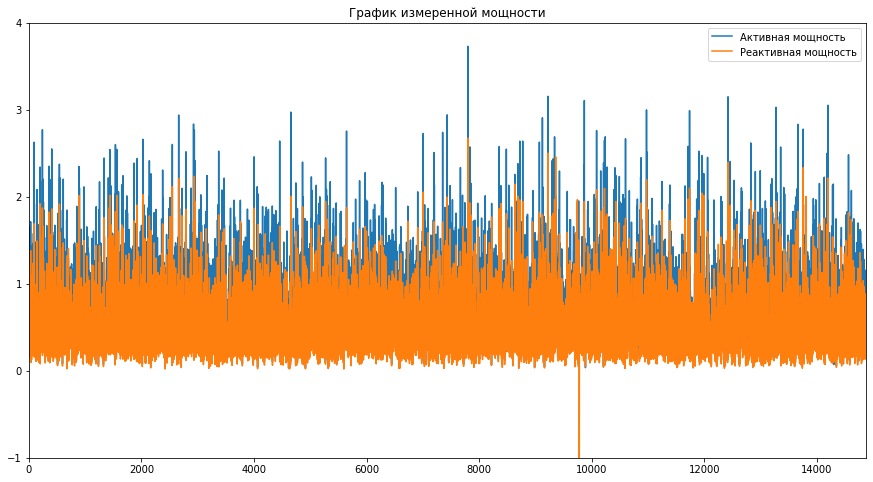

In [4]:
warnings.filterwarnings('ignore')
data_arc[{'Активная мощность', 'Реактивная мощность'}].plot(figsize=(15,8), title = 'График измеренной мощности')
axes = plt.axes()
axes.set_ylim([-1, 4])

In [5]:
data_arc.agg([min, max])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
min,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.030002,-715.504924
max,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,3.731596,2.676388


In [6]:
len(data_arc['key'].unique()) #посчитаем колличество партий

3214

В данных имеется аномальное значение реактивной мощности.

In [7]:
# Меняем формат времени на правильный
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

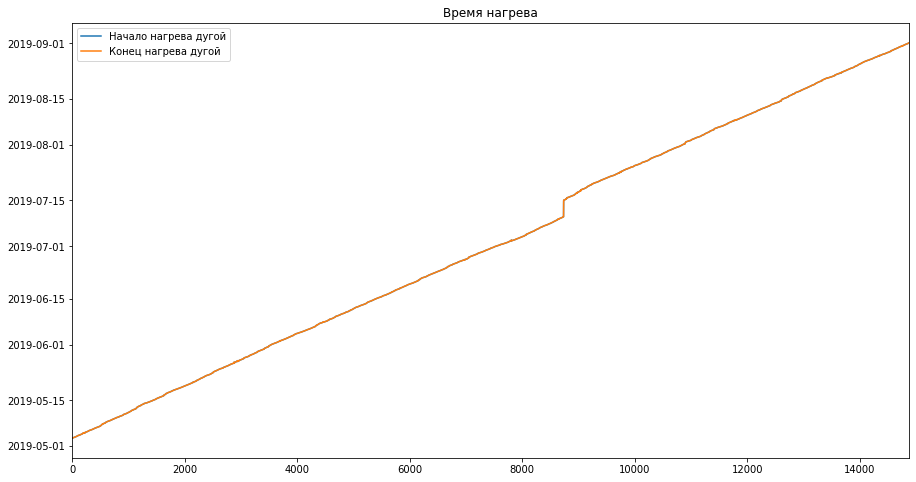

In [8]:
data_arc[{'Начало нагрева дугой', 'Конец нагрева дугой'}].plot(figsize=(15,8), title = 'Время нагрева')

На графике времени есть ступенька. Видимо была оснановка записи или всего техпроцесса. В целом данные записаны последовательно, аномалий нет.

#### Данные о подаче сыпучих материалов (объём и время)

In [9]:
data_bulk.info() #данные о подаче сыпучих материалов (объём)
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


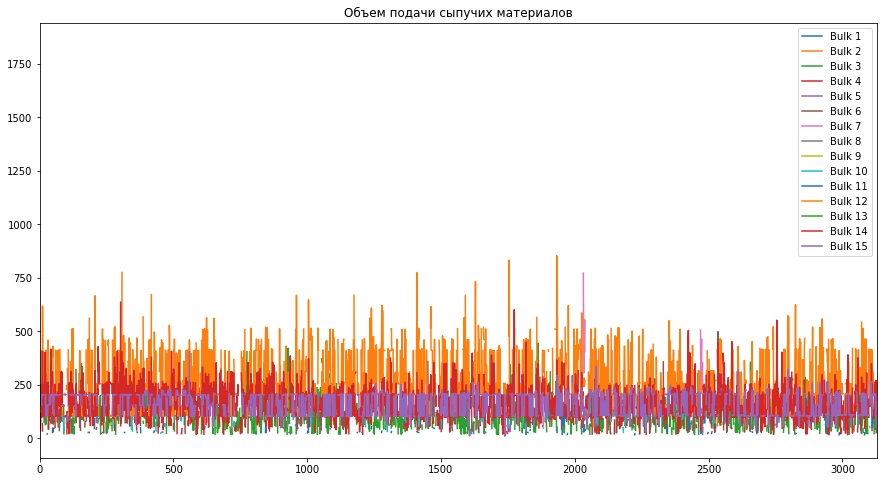

In [10]:
data_bulk.drop(['key'], axis = 1).plot(figsize=(15,8), title = 'Объем подачи сыпучих материалов')

In [11]:
data_bulk.agg([min, max])

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
min,1,10.0,228.0,6.0,12.0,11.0,17.0,47.0,49.0,63.0,24.0,8.0,53.0,151.0,16.0,1.0
max,3241,185.0,325.0,454.0,281.0,603.0,503.0,772.0,49.0,147.0,159.0,313.0,1849.0,305.0,636.0,405.0


In [12]:
data_bulk_time.info() #данные о подаче сыпучих материалов (время)
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [13]:
# Меняем формат времени на правильный
for col_n in range(1,16):
    data_bulk_time['Bulk ' + str(col_n)] = pd.to_datetime(data_bulk_time['Bulk ' + str(col_n)])

(737180.0, 737303.0)

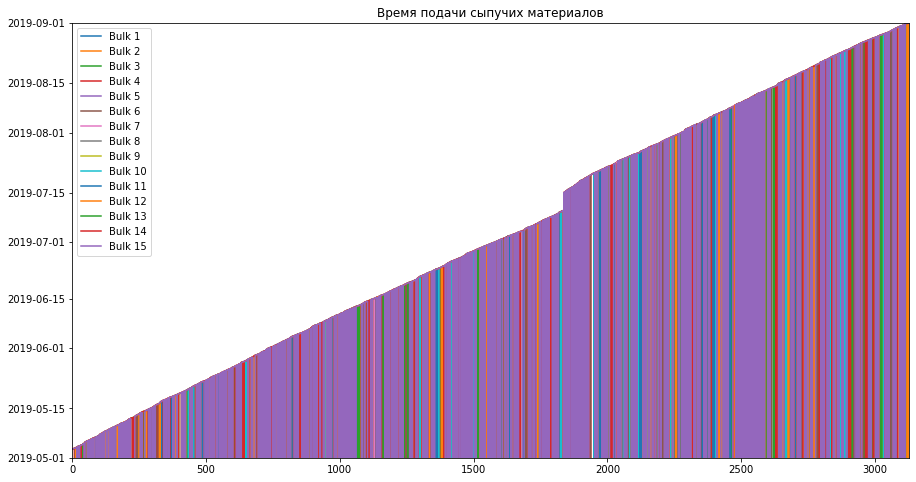

In [14]:
warnings.filterwarnings('ignore')
data_bulk_time.drop(['key'], axis = 1).plot(figsize=(15,8), title = 'Время подачи сыпучих материалов')
axes = plt.axes()
axes.set_ylim([pd.to_datetime('2019-05-01'), pd.to_datetime('2019-09-01')])

В данных о подаче сыпучих материалов аномалий не наблюдается. Данные записаны только в те моменты когда производились опереции, остальное пропуски. Есть ступенька по времени как и в данных по мощности.

#### Данные о продувке сплава газом

In [15]:
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


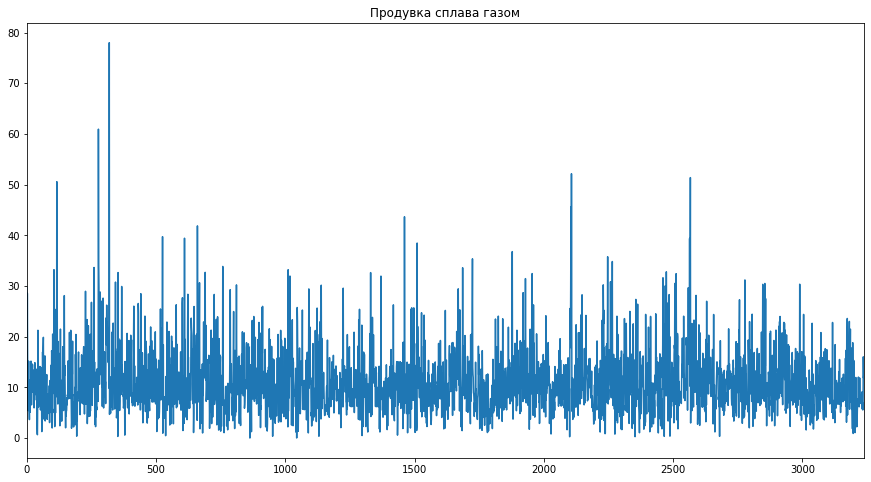

In [16]:
data_gas['Газ 1'].plot(figsize=(15,8), title = 'Продувка сплава газом')

In [17]:
data_gas.agg([min, max])

,key,Газ 1
min,1,0.008399
max,3241,77.995040


In [18]:
len(data_gas['key'].unique()) 

3239

В данных о продувке аномальных значений нет. Однако общее колличество партий не соответсвует максимальному номеру партии. Видимо для некоторых партий данные о газе отсутсвуют.

#### Результаты измерения температуры

In [19]:
data_temp.info() #результаты измерения температуры
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


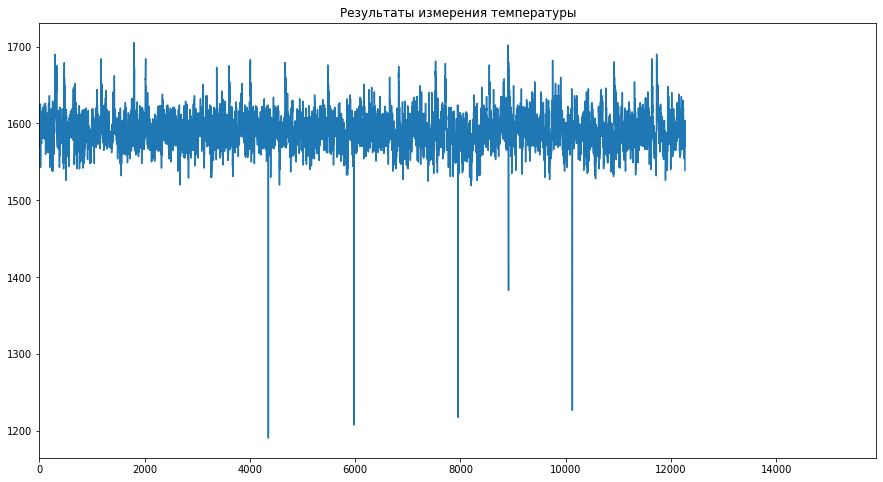

In [20]:
data_temp['Температура'].plot(figsize=(15,8), title = 'Результаты измерения температуры')

In [21]:
data_temp.agg([min, max])

,key,Время замера,Температура
min,1,2019-05-03 11:16:18,1191.0
max,3241,2019-09-01 04:38:08,1705.0


In [22]:
len(data_temp['key'].unique()) 

3216

In [23]:
data_temp.isnull().sum() # Считаем пропуски температуры

key                0
Время замера       0
Температура     2901
dtype: int64

В данных о температуре наблюдается большая потеря данных. Уникальных номеров партий меньше чем максимальный номер партии. Имеются пропуски значений температуры. Кроме того есть аномально низкие значения температуры. Ниже температуры плавления металла. Эти данные лучше исключить.

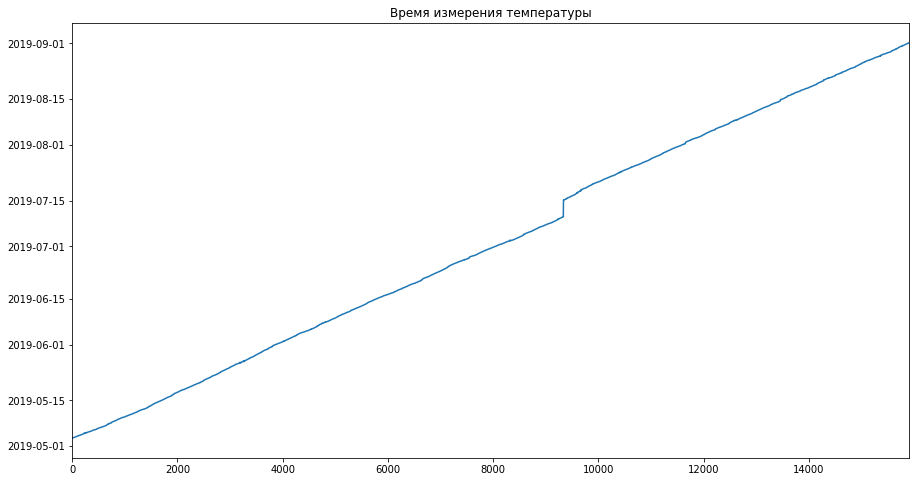

In [24]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp['Время замера'].plot(figsize=(15,8), title = 'Время измерения температуры')

На времени замера темперетуры аномалии не наблюдается. Данные записаны последовательно. Ступенька такая же как и на других замерах.

#### Данные о проволочных материалах (объём и время)

In [25]:
data_wire.info() # данные о проволочных материалах (объём)
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


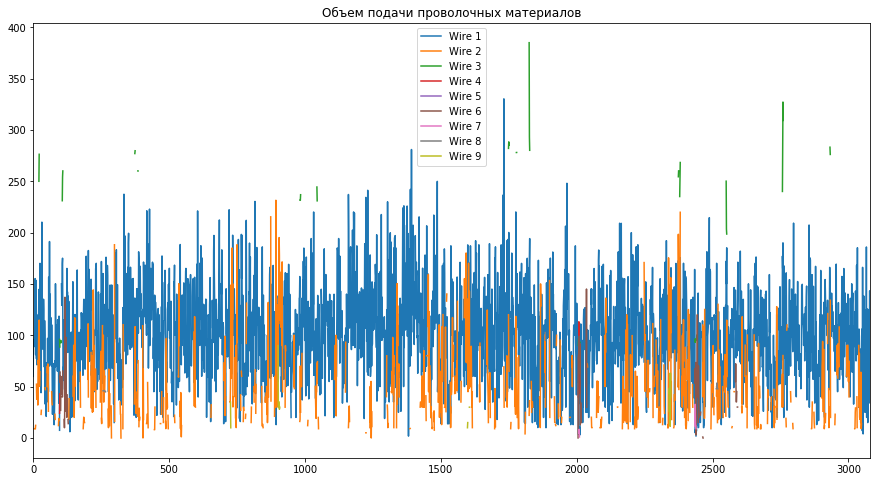

In [26]:
data_wire.drop(['key'], axis = 1).plot(figsize=(15,8), title = 'Объем подачи проволочных материалов')

In [27]:
data_wire.agg(['min', 'max'])

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
min,1,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
max,3241,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [28]:
data_wire_time.info() #данные о проволочных материалах (время)
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Меняем формат времени на правеильный
for col_n in range(1,10):
    data_wire_time['Wire ' + str(col_n)] = pd.to_datetime(data_wire_time['Wire ' + str(col_n)])

(737180.0, 737303.0)

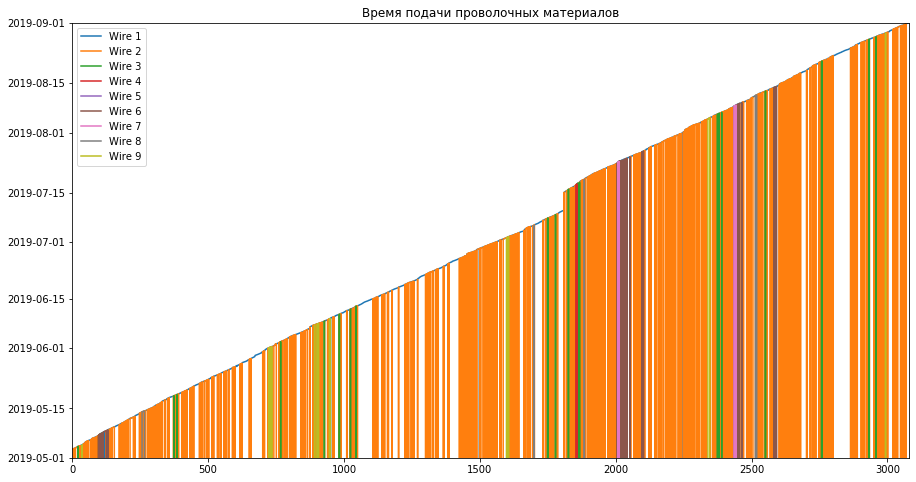

In [30]:
warnings.filterwarnings('ignore')
data_wire_time.drop(['key'], axis = 1).plot(figsize=(15,8), title = 'Время подачи проволочных материалов')
axes = plt.axes()
axes.set_ylim([pd.to_datetime('2019-05-01'), pd.to_datetime('2019-09-01')])

В данных о проволочных материалах аномалий не обнаружено. Данные записаны только в те моменты когда производились опереции, остальное пропуски. Есть ступенька по времени как и всех остальных данных.

### Вывод 

Данные содержат информацию о 3241 партии выплавки стали. Есть несколько аномальных значений в данных мощности и температуры. Есть отсутсвующие данные о температуре и мощности для некоторых партий. Есть пропуски значений темпуратуры. Есть отвутсвующие данные о газе, сыпучих и проволочных материалов для некоторых партий. Есть разрыв в последовательности данных для всех измерений где фиксировалось время. Временные метки приведены в соответсвующий формат.


### План работы

1. *Подготовка данных для обучения.*\
Убрать аномальные значения из данных.\
Подготовить датасет с соответсвующими признаками.\
Проверить признаки на мультиколлинеарность.
2. *Обучить модели.*\
Разделить данные на тренировочную и обучающую выборки.\
Подобрать гиперпараметры модели для минимизации метрики.
3. *Проанализировать модели.*\
Проверить модели на адекватность.\
Проанализировать важность признаков.
4. *Сделать выводы по проекту.* 


## Подготовка данных для обучения.

### Подготовка данных по начальной и конечной температуре одной партии

In [31]:
#Обработка пропусков и аномальных значений для температуры
na_temp_key = data_temp[data_temp.isnull()['Температура'] == True]['key'].unique() #номера паритй с пропусками температуры
anomal_temp_key = data_temp[data_temp['Температура'] < 1500]['key'].unique() #номера паритй с аномальной температурой
drop_temp_key = list(na_temp_key) + list(anomal_temp_key) #номера паритй для удаления

In [32]:
data_temp.drop(data_temp[data_temp.key.isin(drop_temp_key)].index, inplace=True)

In [33]:
data_temp.head(6)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0


In [34]:
temp_t1 = data_temp.sort_values(by='Время замера').groupby('key').first()
temp_t2 = data_temp.sort_values(by='Время замера').groupby('key').last()
data_temp_t1t2 = pd.DataFrame({'key':temp_t1.index,
                               'Начало замера температуры':temp_t1['Время замера'].values,
                               'Конец замера температуры':temp_t2['Время замера'].values,
                               'Начальная температура':temp_t1['Температура'].values,
                               'Конечная температура':temp_t2['Температура'].values})
data_temp_t1t2.head()

,key,Начало замера температуры,Конец замера температуры,Начальная температура,Конечная температура
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


### Подготовка данных по затраченной энергии на нагрев одной партии

В расчетах будем спользовать только активную энергию, так как реативная на нагрев не используется, кроме того активная и реактивная энергии зависят друг от друга. Аномальное значение в реактивной мощности игнорируем. Просуммируем все сеансы нагрева в одной партии. Для контроля последовательности процесса выдолим начало первого и конец последнего сеанса нагрева. 

In [35]:
# считаем столбец с активной энергией E = P * t. Время берем в секундах
data_arc['Активная энергия'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).astype('timedelta64[s]') *\
                                                                                                 data_arc['Активная мощность']
data_arc.head(6)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Активная энергия
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,102.527702
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,60.014678


In [36]:
#считем суммарную энергию
sum_active_energy = data_arc.groupby('key')['Активная энергия'].sum()
arc_t_start = data_arc.groupby('key')['Начало нагрева дугой'].min()
arc_t_finish = data_arc.groupby('key')['Конец нагрева дугой'].max()

data_arc_sumE = pd.DataFrame({'key':sum_active_energy.index, 
                              'Активная энергия':sum_active_energy.values,
                              'Начало нагрева':arc_t_start.values,
                              'Конец нагрева':arc_t_finish.values})
data_arc_sumE.head()

,key,Активная энергия,Начало нагрева,Конец нагрева
0,1,1207.804249,2019-05-03 11:02:14,2019-05-03 11:28:37
1,2,733.816470,2019-05-03 11:34:14,2019-05-03 11:53:18
2,3,443.583327,2019-05-03 12:06:54,2019-05-03 12:32:19
3,4,670.663327,2019-05-03 12:39:37,2019-05-03 12:57:50
4,5,997.496095,2019-05-03 13:11:13,2019-05-03 13:33:55


### Подготовка данных о подаче сыпучих материалов

В этих данных пропуски означают что сыпучих материалов не подавалось, поэтому заполним нулями.

In [37]:
data_bulk = data_bulk.fillna(0)

In [38]:
# Добавим время начала и конца подачи
data_bulk['Начало подачи сыпучих'] = data_bulk_time.drop(['key'], axis = 1).min(axis=1)
data_bulk['Конец подачи сыпучих'] = data_bulk_time.drop(['key'], axis = 1).max(axis=1)

In [39]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Начало подачи сыпучих,Конец подачи сыпучих
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,2019-05-03 11:03:52,2019-05-03 11:21:30
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,2019-05-03 11:40:20,2019-05-03 11:46:38
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,2019-05-03 12:09:40,2019-05-03 12:31:06
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,2019-05-03 12:41:24,2019-05-03 12:48:43
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,2019-05-03 13:12:56,2019-05-03 13:18:50


### Подготовка данных о подаче проволочных материалов

В этих данных пропуски означают что проволичных материалов не подавалось, поэтому заполним нулями

In [40]:
data_wire = data_wire.fillna(0) 

In [41]:
# Добавим время начала и конца подачи
data_wire['Начало подачи проволочных'] =  data_wire_time.drop(['key'], axis = 1).min(axis=1)
data_wire['Конец подачи проволочных'] = data_wire_time.drop(['key'], axis = 1).max(axis=1)

In [42]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Начало подачи проволочных,Конец подачи проволочных
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:11:41,2019-05-03 11:11:41
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:46:10,2019-05-03 11:46:10
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:13:47,2019-05-03 12:13:47
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:48:05,2019-05-03 12:48:05
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:18:15,2019-05-03 13:32:06


### Общий dataset

In [43]:
df = data_temp_t1t2.merge(data_arc_sumE, on='key')\
                   .merge(data_bulk, on='key')\
                   .merge(data_wire, on='key')\
                   .merge(data_gas, on='key')
df

,key,Начало замера температуры,Конец замера температуры,Начальная температура,Конечная температура,Активная энергия,Начало нагрева,Конец нагрева,Bulk 1,Bulk 2,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Начало подачи проволочных,Конец подачи проволочных,Газ 1
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,1207.804249,2019-05-03 11:02:14,2019-05-03 11:28:37,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:11:41,2019-05-03 11:11:41,29.749986
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,733.816470,2019-05-03 11:34:14,2019-05-03 11:53:18,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:46:10,2019-05-03 11:46:10,12.555561
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,443.583327,2019-05-03 12:06:54,2019-05-03 12:32:19,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:13:47,2019-05-03 12:13:47,28.554793
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,670.663327,2019-05-03 12:39:37,2019-05-03 12:57:50,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:48:05,2019-05-03 12:48:05,18.841219
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,997.496095,2019-05-03 13:11:13,2019-05-03 13:33:55,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:18:15,2019-05-03 13:32:06,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,626.167357,2019-08-06 00:31:05,2019-08-06 00:51:13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 00:36:13,2019-08-06 00:36:13,7.125735
2321,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,727.868032,2019-08-06 01:00:06,2019-08-06 01:23:32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 01:13:33,2019-08-06 01:13:33,9.412616
2322,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,427.535518,2019-08-06 01:38:01,2019-08-06 01:50:45,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 01:42:27,2019-08-06 01:42:51,6.271699
2323,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,629.928649,2019-08-06 01:57:46,2019-08-06 02:20:24,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 02:04:20,2019-08-06 02:04:20,14.953657


### Проверка последовательности технологического процесса


Все технологические процессы (нагрев, добавление сыпучих материалов, добавление проволосных мтериалов) должны выполнятся в период времени между превым и последним замером температуры. Проверим это условие сравнивая время начала и конца технологических процессов с временем замера температуры.

In [44]:
df = df[
        (df['Конец замера температуры']>df['Конец подачи проволочных']) & 
        (df['Конец замера температуры']>df['Конец подачи сыпучих']) &
       (df['Конец замера температуры']>df['Конец нагрева'])# & 
    #   (df['Начало замера температуры']<df['Начало подачи проволочных']) &
     #  (df['Начало замера температуры']<df['Начало подачи сыпучих']) &
    #   (df['Начало замера температуры']<df['Начало нагрева'])
           ]
df

,key,Начало замера температуры,Конец замера температуры,Начальная температура,Конечная температура,Активная энергия,Начало нагрева,Конец нагрева,Bulk 1,Bulk 2,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Начало подачи проволочных,Конец подачи проволочных,Газ 1
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,1207.804249,2019-05-03 11:02:14,2019-05-03 11:28:37,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:11:41,2019-05-03 11:11:41,29.749986
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,733.816470,2019-05-03 11:34:14,2019-05-03 11:53:18,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 11:46:10,2019-05-03 11:46:10,12.555561
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,443.583327,2019-05-03 12:06:54,2019-05-03 12:32:19,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:13:47,2019-05-03 12:13:47,28.554793
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,670.663327,2019-05-03 12:39:37,2019-05-03 12:57:50,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 12:48:05,2019-05-03 12:48:05,18.841219
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,997.496095,2019-05-03 13:11:13,2019-05-03 13:33:55,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-03 13:18:15,2019-05-03 13:32:06,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,626.167357,2019-08-06 00:31:05,2019-08-06 00:51:13,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 00:36:13,2019-08-06 00:36:13,7.125735
2321,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,727.868032,2019-08-06 01:00:06,2019-08-06 01:23:32,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 01:13:33,2019-08-06 01:13:33,9.412616
2322,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,427.535518,2019-08-06 01:38:01,2019-08-06 01:50:45,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 01:42:27,2019-08-06 01:42:51,6.271699
2323,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,629.928649,2019-08-06 01:57:46,2019-08-06 02:20:24,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-06 02:04:20,2019-08-06 02:04:20,14.953657


Отфильтровали данные только по концу техпроцесса. В большинстве случаев первая температура замеряется когда уже включен нагрев. Если фильтровать это условие остается всего 30 партий.

In [45]:
df = df.drop(df.select_dtypes(include=['datetime64[ns]']).columns, axis=1) #удалим столбцы с временем
df = df.drop('key', axis=1) #удалим столбец с номером партии

In [46]:
df.head()

,Начальная температура,Конечная температура,Активная энергия,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1571.0,1613.0,1207.804249,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,1581.0,1602.0,733.816470,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1596.0,1599.0,443.583327,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,1601.0,1625.0,670.663327,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,1576.0,1602.0,997.496095,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


### Проверка признакиов на мультиколлинеарность

Посчитаем корреляцию для основных признаков. В качестве добавок выборем 'Wire 1', 'Bulk 4'.

In [47]:
df[{'Начальная температура', 'Конечная температура','Активная энергия', 'Газ 1','Wire 1', 'Bulk 4'}]\
.corr().style.set_caption("Корреляция признаков").background_gradient(cmap='coolwarm').set_precision(2)

,Конечная температура,Wire 1,Активная энергия,Газ 1,Начальная температура,Bulk 4
Конечная температура,1,0.32,0.3,0.061,0.3,0.2
Wire 1,0.32,1,0.016,0.11,0.26,0.3
Активная энергия,0.3,0.016,1,0.31,-0.41,-0.039
Газ 1,0.061,0.11,0.31,1,0.046,0.0093
Начальная температура,0.3,0.26,-0.41,0.046,1,0.17
Bulk 4,0.2,0.3,-0.039,0.0093,0.17,1


Явно зависящих друг от друга признаков нет.

### Разделение на обучающую и тестовую выборки

In [48]:
#выделим целевой признак
features = df.drop('Конечная температура', axis = 1)
target = df['Конечная температура']

In [49]:
features_train, features_test, target_train, target_test  = train_test_split(features, target, test_size=0.25, random_state=12345)

print('Обучающие объекты: признаки {}, цель {}'.format(features_train.shape, target_train.shape))
print('Тестовые объекты: признаки {}, цель {}'.format(features_test.shape, target_test.shape))

Обучающие объекты: признаки (1651, 27), цель (1651,)
Тестовые объекты: признаки (551, 27), цель (551,)


## Обучение моделей

В качестве моделей выберем линейную регрессию слуйный регрессионый лес.

In [50]:
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predictions_LR_train = model_LR.predict(features_train)
MAE_LR_train = mean_absolute_error(target_train, predictions_LR_train)
print("MAE для линейной регрессии на обоучающей выборке", MAE_LR_train)

MAE для линейной регрессии на обоучающей выборке 6.255603313580879


In [51]:
predictions_LR_test = model_LR.predict(features_test)
MAE_LR_test = mean_absolute_error(target_test, predictions_LR_test)
MAE_LR_test
print("MAE для линейной регрессии на тестовой выборке", MAE_LR_test)

MAE для линейной регрессии на тестовой выборке 5.877501389852804


In [52]:
%%time
parametrs_RFR = {'n_estimators': range (50,200,25),
                 'min_samples_leaf': range (2,6,2),
                 'min_samples_split': range (2,6,2) }
warnings.filterwarnings("ignore")
model_RFR = GridSearchCV(RandomForestRegressor(random_state=12345), parametrs_RFR, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
model_RFR.fit(features_train, target_train)
predictions_RFR_train = model_RFR.best_estimator_.predict(features_train)
MAE_RFR_train = mean_absolute_error(target_train, predictions_RFR_train)
print("MAE для случайного регрессионного леса на тренировочной выборке", MAE_RFR_train)
print("MAE для случайного регрессионного леса на кросвалидационной выборке", model_RFR.best_score_)
print("Лучшие параметры для RandomForestRegressor:", model_RFR.best_params_)

MAE для случайного регрессионного леса на тренировочной выборке 3.5983223939739433
MAE для случайного регрессионного леса на кросвалидационной выборке -6.121451408382796
Лучшие параметры для RandomForestRegressor: {'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 175}
Wall time: 23.9 s


In [53]:
predictions_RFR_test = model_RFR.best_estimator_.predict(features_test)
MAE_RFR_test = mean_absolute_error(target_test, predictions_RFR_test)
print("MAE для случайного регрессионного леса на тестовой выборке", MAE_RFR_test)

MAE для случайного регрессионного леса на тестовой выборке 5.969244268847501


## Анализ моделей

### Проверка адекватности моделей

Проверим адекватность модели на обучающей выборке.

In [54]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features_train, target_train)
predictions_dummy = dummy_regr.predict(features_train)
MAE_DR_train = mean_absolute_error(target_train, predictions_dummy)
print("MAE для константы на тренровочной выборке", MAE_DR_train)

MAE для константы на тренровочной выборке 8.132646880678378


Проверим адекватность модели на тестовой выборке.

In [55]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features_test, target_test)
predictions_dummy = dummy_regr.predict(features_test)
MAE_DR_test = mean_absolute_error(target_test, predictions_dummy)
print("MAE для константы на тестовой выборке", MAE_DR_test)

MAE для константы на тестовой выборке 7.9346642468239565


Метрики на константной модели значительно выше чем на обученных моделях. Модели адекватны

### Анализ важности признаков

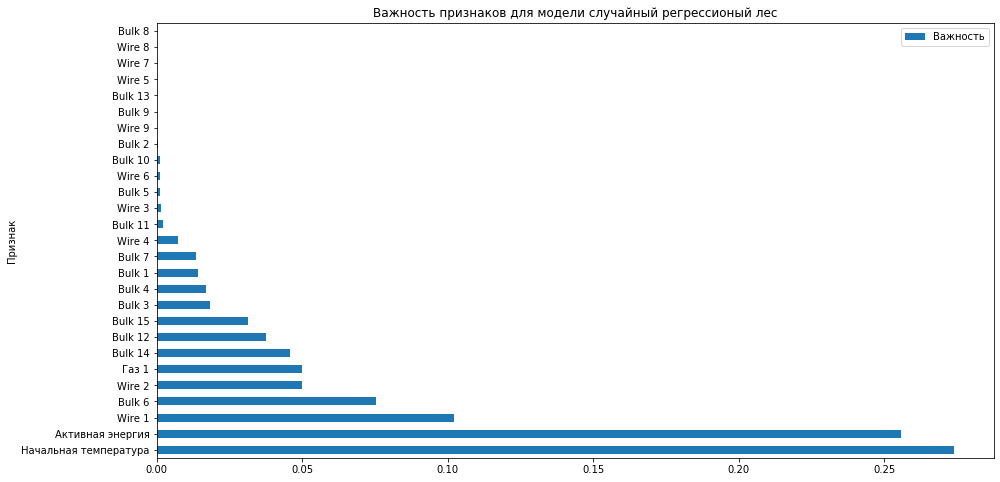

In [56]:
importances = model_RFR.best_estimator_.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'Признак': feature_list,'Важность': importances})
feature_results = feature_results.sort_values('Важность',ascending = False).reset_index(drop=True)
feature_results.plot(x='Признак', y='Важность',  kind = 'barh', title='Важность признаков для модели случайный регрессионый лес', figsize=(15,8))
plt.show()

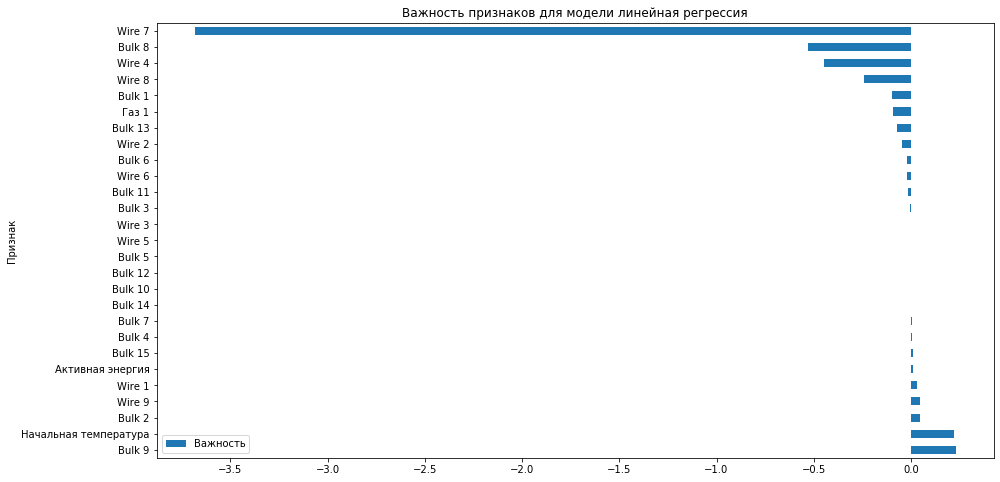

In [57]:
importances = model_LR.coef_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'Признак': feature_list,'Важность': importances})
feature_results = feature_results.sort_values('Важность',ascending = False).reset_index(drop=True)
feature_results.plot(x='Признак', y='Важность',  kind = 'barh', title='Важность признаков для модели линейная регрессия', figsize=(15,8))
plt.show()

Судя по этим данным половину признаков можно убрать из модели. Это примеси которые редко используются в техпроцессе.

## Результаты

In [58]:
result = {'Модель': ['Константная модель', 'Случайный регрессионый лес', 'Линейная регрессия'], 
          'MAE для тренировочной выборки': [MAE_DR_train, MAE_RFR_train, MAE_LR_train],
          'MAE для тестовой выборки': [MAE_DR_test, MAE_RFR_test, MAE_LR_test]}
test_result = pd.DataFrame(result)
test_result

,Модель,MAE для тренировочной выборки,MAE для тестовой выборки
0,Константная модель,8.132647,7.934664
1,Случайный регрессионый лес,3.598322,5.969244
2,Линейная регрессия,6.255603,5.877501


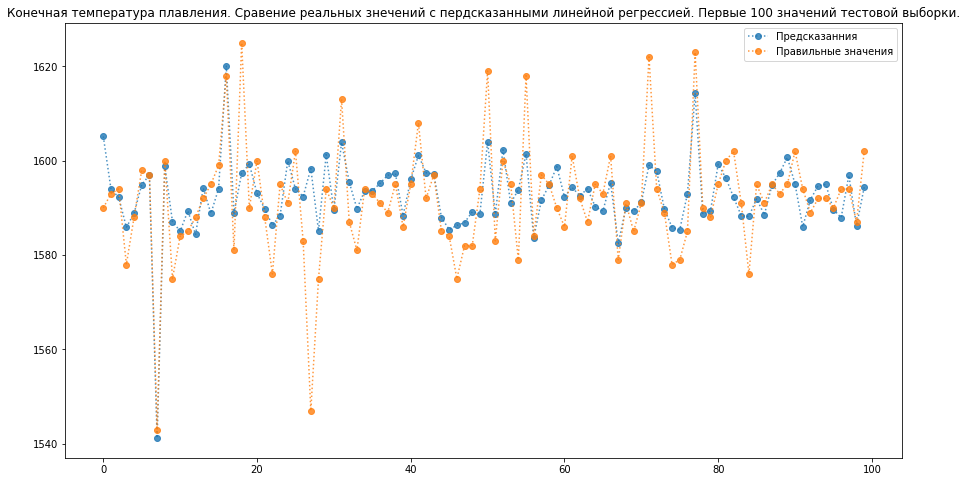

In [59]:
y1 = pd.DataFrame(predictions_LR_test)
y2 = target_test.reset_index()['Конечная температура']
plt.figure(figsize=(15,8))
plt.plot(y1[:100], ':o', alpha=0.8, label='Предсказанния')
plt.plot(y2[:100], ':o', alpha=0.8, label='Правильные значения')
plt.legend()
plt.title('Конечная температура плавления. Сравение реальных знечений с пердсказанными линейной регрессией. Первые 100 значений тестовой выборки.')
plt.show()

## Отчёт по решению

План работы содержал слудующие пункты:

1. *Подготовка данных для обучения.*\
Убрать аномальные значения из данных.\
Подготовить датасет с соответсвующими признаками.\
Проверить признаки на мультиколлинеарность.
2. *Обучить модели.*\
Разделить данные на тренировочную и обучающую выборки.\
Подобрать гиперпараметры модели для минимизации метрики.
3. *Проанализировать модели.*\
Проверить модели на адекватность.\
Проанализировать важность признаков.
4. *Сделать выводы по проекту.*<br>

В ходе выполнения проекта все пункты плана были выполнены.
    
При подготовке данных для обучения особое внимание уделялось адекватности значений измеряемых парамтров. Поэтому пропуски и аномальные значения не восстанавливались а удалялись всмести с остальными значениями относящимися к этой партии. Так же проверялась последовательность получения данных согласно временным меткам. 
    
При сотставлении набора признаков для обучения модели из исходых данных были выделены начальная и конечная температура, затраченнуая энергия, газ и набор примесей. Целевой признак - конечная температура.

По исходным данным было видно что некоторые примеси используются значительно реже других. И как потом показал анализ важности признаков обученной модели они практически не плияют на результат предсказания. Т.е. модель может быть оптимизирована сокращением количества признаков.

Для проверки на мультиколлинеарность использовались 6 основных признаков. В качестве примесей использовались 'Wire 1'и 'Bulk 4'. Корреляционный анализ не показал явных зависимостей.

В качестве моделей были выбраны линейная регрессия и случайный реграссионный лес. Для случайного регрессионного леса использовался подбор гиперпараметров с применение кроссвалидации. Обе модели показали результат на тестовой выборке удовлетворяющий максимальные требования тимлида MAE<6.  Обе модели прошли проверку на адекватность сравенением с константной медианной моделью.

В итоге можно остановится на модели линейная регрессия по двум причинам: 1) она показывает лучший результат на тестовой выборке; 2)нет необходимости подбирать гиперпараметры при обучении а следовательно проще переобучать при изменении техпроцесса.


Анализ признаков показал, что самым важным фактором является первая температура. Управляя ею, мы сможем управлять энергозатратами.